# Data and Databooks

This page provides an overview of Atomica's internal representation of databooks. Project data for an application is specified in a 'databook'. This is an Excel file that contains

- A listing of which populations a simulation will have
- A specification of which transfers are present
- Population and time specific values for characteristics, parameters, transfers, and interactions

`ProjectData` is a Python object containing the data, and it has methods to convert to and from the databook spreadsheet.

In [ ]:
import pandas as pd
import atomica as at
import matplotlib.pyplot as plt
import numpy as np
import sciris as sc

with at.Quiet(show_warnings=False): # Temporarily suppress any warnings from the output
    F = at.ProjectFramework(at.LIBRARY_PATH / "tb_framework.xlsx")
    data = at.ProjectData.from_spreadsheet(at.LIBRARY_PATH / "tb_databook.xlsx",F)

We have now loaded in a framework, and a corresponding databook as a `ProjectData` object. The `ProjectData` object contains a number of attributes

- `pops` is an odict storing populations, their full names, and the population type (if multiple population types are present)
- `tvec` stores the default time array associated with the data (users can override this on a per-table basis)
- `transfers` and `interactions` store pairwise time series linking populations
- `tdve` stores a dict of `TimeDependentValueEntry` tables for characteristics and parameters
- `tdve_pages` stores a dict assigning TDVE tables to worksheets

There are three basic elements to the databook

1. The population table
2. `TimeDependentConnection` tables which are used for transfers and interactions. These have a 'to' and a 'from' population
3. `TimeDependentValueEntry` tables which are used for characteristics and parameters

## `TimeSeries` objects

Time-varying data is backed by the `TimeSeries` object defined in `structure.py`. This object stores sparse time-varying data, together with an assumption. This allows it to keep track of both assumption and time-varying values entered in a databook. It has a few key properties

In [ ]:
ts = at.TimeSeries(t=[2014,2015],vals=[1,2])

A TimeSeries has `t` and `vals` attributes that store the time varying data

In [ ]:
ts.t

In [ ]:
ts.vals

The values can be modified using the `insert` and `remove` methods. These preserve the order of the times. Notice that the `remove` method removes data based on the time value rather than the index.

In [ ]:
ts.insert(2016,3)
ts.remove(2015)
ts.vals

A `TimeSeries` object also has an interpolate method to query its value at arbitrary times. It uses the same interpolation as for parameters, with constant extrapolation

In [ ]:
t = np.arange(2013,2018,0.2)
plt.plot(t,ts.interpolate(t))

One of the special features of the `TimeSeries` object that caters for databook entry is the fact that it can independently store the constant assumption value. This is set by inserting a value with no time associated with it

In [ ]:
ts2 = at.TimeSeries()
ts2.insert(None,2)
ts2.assumption

Since the data for a `TimeSeries` could be in `assumption` or in `vals`, the method `get_arrays` allows you to get time and value arrays for the content of the `TimeSeries`

In [ ]:
t,v = ts.get_arrays()
print(t)
print(v)

t,v = ts2.get_arrays()
print(t)
print(v)

However, the most common usage for the `TimeSeries` is to turn sparse data into full interpolated arrays. The `interpolate` method automatically manages the assumption and the time dependent values, so that you don't have to do this yourself:

In [ ]:
t = np.arange(2013,2018,0.2)
plt.plot(t,ts.interpolate(t),label='Time varying')
plt.plot(t,ts2.interpolate(t),label='Assumption')
plt.legend()

The `TimeSeries` object also has a `units` property that lets it store the units of the quantity entered in the databook.

<div class="alert alert-info">
In general, whenever the databook has a time-dependent values row with an assumption and some year-specific data, the corresponding object used to store the data on that row is a `TimeSeries`

### Population table

The population table is very basic:

![databook-population-example](databook_population_example.png)

If population types are present (e.g., if modelling both humans and a vector like mosquitos) there will be additional columns in this table - see the documentation pages for 'Population types' for more information.

### TimeDependentConnections

![databook-tdc](databook_tdc.png)

A `TimeDependentConnections` table consists of three elements

1. A code name/full name table at the top
2. A matrix of Y/N values that controls which time series appear on the page
3. A set of time series inputs where the user enters time-varying data

This table is managed by the `TimeDependentConnections` object in `excel.py` which has

- A code name
- A full name
- The type (whether it's an interaction or a transfer - the difference being, a transfer cannot have any entries on the diagonal i.e. within the same population)
- A list of population names
- A list of times
- A dict of `TimeSeries` objects keyed by the `(to,from)` populaton names
- A method `from_tables()` to construct a `TimeDependentConnections` instance based on the rows in the spreadsheet
- A method `write()` that takes in a sheet and a start row, and writes the content for the object to the spreadsheet

### TimeDependentValuesEntry

![databook-tdve](databook_tdve.png)

A `TimeDependentValuesEntry` consists of a single element with

- The full name of the quantity at the top left
- The left column with population names
- Value entry cells for contant and year-specific values

    A code name/full name table at the top
    A matrix of Y/N values that controls which time series appear on the page
    A set of time series inputs where the user enters time-varying data

This table is managed by the `TimeDependentValuesEntry` object in `excel.py` which has

- A name
- The time vector
- A dict of `TimeSeries` objects keyed by the population name
- A method `from_rows()` to construct a `TimeDependentValuesEntry` instance based on the rows in the spreadsheet
- A method `write()` that takes in a sheet and a start row, and writes the content for the object to the spreadsheet

It is possible to optionally specify a row with the population set to 'All'. This row will then serve as a fallback for any populations that are otherwise missing in the table. Since 'All' is a reserved keyword, it is guaranteed to not correspond to an actual population. If a row with 'All' is present, it is not necessary to specify any other data in the TDVE table. However, if population-specific rows are present, they will take precedence. The values for the 'All' population row are processed when constructing a `ParameterSet` - the `ParameterSet` will contain time series values for every population, and will read them from the 'All' row of the TDVE table as required. In that sense, having a row for 'All' in the TDVE table is functionally equivalent to the databook containing population specific rows for every population, with the same data appearing on every row.

## Modifying databooks

A `ProjectData` instance is essentially a Python representation of the databook spreadsheet, and you can freely move between either representation depending on which is easiest to work with for any given task. In particular, this functionality facilitates programmatic editing of the databook, which can be useful in several common workflows.

### Creating a blank databook

Starting from a framework, you can make a blank databook using the `at.ProjectData.new()` function:

In [ ]:
F = at.ProjectFramework('sir_framework.xlsx')
D = at.ProjectData.new(framework=F, pops=1, transfers=0, tvec=np.arange(2020, 2041))

This has produced an empty `ProjectData` instance. It can be converted and saved to a spreadsheet databook format using the `save` method

In [ ]:
D.save('sir_databook_1.xlsx')

![databook-new1](new_1.png)

### Pre-populating data

The tables in the databook are stored in the `ProjectData` instance under three member variables

- `tdve` stores the compartment, characteristic, and parameter input tables
- `transfers` stores any inter-population transfers such as aging
- `interactions` stores any cross-population variable weights, such as those used for computing force of infection

The entries in `tdve` exactly match the quantities in the framework flagged as appearing in the databook, while the entries in `transfers` and `interactions` are databook-specific (because they depend on the populations defined in the databook). By accessing these variables, we can programatically read and write values in the data. For example:

In [ ]:
D.tdve.keys()

In [ ]:
D.tdve['sus']

The `tdve` entry for the `sus` variable contains various metadata controlling which columns appear in the databook. The values are stored within `TimeSeries` instances in the `ts` attribute, keyed by population:

In [ ]:
D.tdve['sus'].ts['pop_0']

Since the various time series in the databook could be stored in either a TDVE table or a transfer or an interaction, the `ProjectData.get_ts()` can be used to access variables by name and population, regardless of where in the `ProjectData` instance they are stored:

In [ ]:
D.get_ts('sus','pop_0')

To insert a value, we can simply add the value to this time series

In [ ]:
D.tdve['sus'].ts['pop_0'].insert(2020, 1000)

Note that the year must be present in the TDVE's `tvec` in order for the values to be written to the databook. To add different years on an individual basis, manually add the years to the `tvec` first.

In [ ]:
D.save('sir_databook_2.xlsx')

![databook-new2](new_2.png)

Now when the `ProjectData` instance is saved to disk, the inserted value is written into the spreadsheet. As an alternative to inserting values one-by-one, you could alternatively replace the entire timeseries:

In [ ]:
D.tdve['ch_all'].ts['pop_0'] = at.TimeSeries([2020, 2025, 2030], [2000, 3000, 4000], units='Number')
D.tdve['ch_prev'].ts['pop_0'] = at.TimeSeries([2021, 2022], [0.3, 0.28], units='Fraction')

D.save('sir_databook_3.xlsx')

![databook-new3](new_3.png)

This approach can be extended to pre-populate many different variables in a script. For example, a common workflow is to have a collection of raw data files from various sources. Then to produce a databook, a blank databook is created from the framework, the raw inputs read into dataframes, and then the values inserted into the appropriate time series before writing the databook to disk. Any additional missing values can then be populated manually before the databook is then loaded back and used to run simulations. This workflow is particularly useful if conducting an analysis in multiple settings, where several databooks are required. The input data spreadsheet might correspond to one type of quantity (e.g., population size) for every country all from a single source, and a script to generate databooks would read data for a specific country from each of the input spreadsheets to generate multiple databooks.

### Adding a variable

Another common use case is when a framework has been updated to contain a new variable. How can this new variable be added to an existing databook? The *easiest* way to do this is actually to simply make a copy of the sub-table in Excel, populate values as required, and then load the new databook. For example, consider modifying the framework to contain:

![databook-framework2](framework_2.png)

Suppose we try to load the existing databook using this framework:

In [ ]:
F2 = at.ProjectFramework('sir_framework_2.xlsx')
D2 = at.ProjectData.from_spreadsheet('sir_databook_3.xlsx', framework=F2)

The databook can be loaded even though the `vac` table is missing. However, the databook will not pass validation because it does not contain the missing variable

In [ ]:
try:
    D2.validate(F2)
except Exception as E:
    print(E)

Adding a new TDVE to `D2.tdve['vac']` would be possible - however, the additional metadata such as the allowed units for that variable would need to be added as well, and it would need to be assigned to a databook page, so overall this would be somewhat fragile and error prone. Instead, an option could be to make a new databook from the framework, and copy any relevant TDVEs from the old databook to the new databook. For example:

In [ ]:
D1 = at.ProjectData.from_spreadsheet('sir_databook_3.xlsx', framework=F)
D2 = at.ProjectData.new(framework=F2, pops=1, transfers=0, tvec=np.arange(2020, 2041))
for k,v in D1.tdve.items():
    if k in D2.tdve:
        D2.tdve[k] = v
D2.save('sir_databook_4.xlsx')

![databook-new4](new_4.png)

Notice how the sheet now contains all of the original data, as well as the new 'Vaccinated' table. However, this approach has the limitation of requiring access to the original framework. 

<div class="alert alert-block alert-info">
In general, the preferred workflow for adding new variables to the databook is to simply edit the existing databook in Excel to match the required format, by copying-and-pasting the existing tables. Any issues with formatting can be tidied by loading the databook into Atomica and saving it back, to re-write it with standard formatting.
</div>



### Removing a variable

Removing a variable follows a similar workflow as adding a variable. Suppose we have now removed the `ch_prev` variable ('Prevalence') from the databook:

![databook-framework3](framework_3.png)

In [ ]:
F3 = at.ProjectFramework('sir_framework_3.xlsx')
D3 = at.ProjectData.from_spreadsheet('sir_databook_3.xlsx', framework=F3)
D3.validate(F3);

Unlike the previous example where a new variables was required, the existing databook is valid for use with the new framework, because the additional variable is simply surplus and does not otherwise interact with the model. However, to remove it, you can otherwise delete it from the dictionary:

In [ ]:
del D3.tdve['ch_prev']
D3.tdve_pages['State Variables'].remove('ch_prev')
D3.save('sir_databook_5.xlsx')

Notice that the `tdve_pages` attribute maps TDVE entries (like `ch_prev`) to databook sheets (like `'State variables'`):

In [ ]:
D3.tdve_pages

You can use the `tdve_pages` attribute to move tables from one sheet to another. However, that also means that if you add or remove an entry from `tdve` you will need to make a corresponding change to `tdve_pages`. 

<div class="alert alert-block alert-info">
In general, the preferred workflow for removing variables from a databook is to simply delete the relevant rows from the existing databook.
</div>

### Add/remove populations

Adding or removing populations requires modifying the rows in every TDVE and TDC instance contained in the databook. Therefore, the `ProjectData` instance provides methods to facilitate these operations:

In [ ]:
D3.add_pop(code_name='adults', full_name='Adults')
D3.add_pop(code_name='children', full_name='Children')
D3.save('sir_databook_6.xlsx')

The new populations now appear on the population definitions sheet, and in every TDVE table.

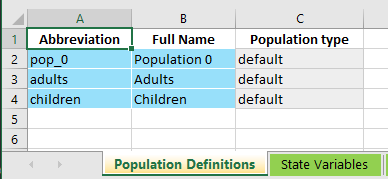

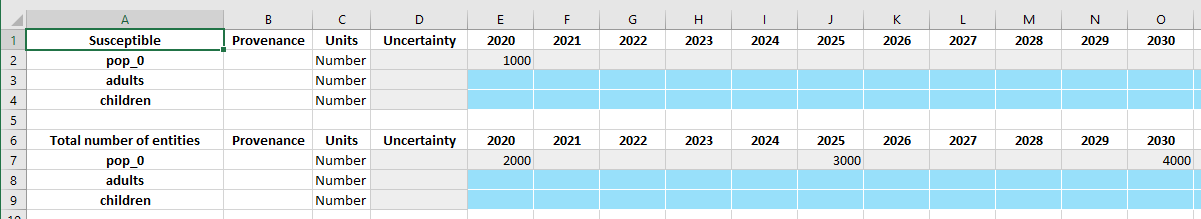

Removing a population can be done in much the same way:

In [ ]:
D3.remove_pop('children')
D3.save('sir_databook_7.xlsx')

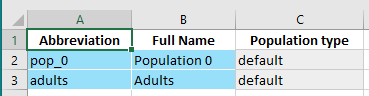

Finally, a population can be renamed using the 'rename_pop' method. This is different to adding a new population with a new name and then removing the original one, because it preserves any data already entered:

In [ ]:
D3.rename_pop('pop_0', new_code_name='general', new_full_name='General')
D3.save('sir_databook_8.xlsx')

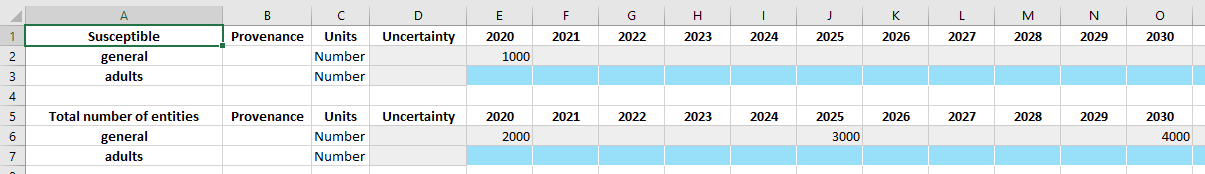

Notice that the data values that were previously entered for the `pop_0` population have been preserved.

### Add/remove transfers and interactions

Transfers and interactions can be added or removed in the same way as populations, using 

- `ProjectData.add_transfer()`
- `ProjectData.rename_transfer()`
- `ProjectData.remove_transfer()`
- `ProjectData.add_interaction()`
- `ProjectData.remove_interaction()`

### Changing databook years

The year range in the databook is defined at the TDVE/TDC level, and therefore each quantity can have a different set of time values. In Excel, to add an extra year to a table, simply add an extra column to the appropriate variable. When programatically modifying the time points at the variable level, it's important to make the change at the `tvec` level rather than the `ts` (timeseries) level, so that the change propagates to the databook when exported. This is shown in the example above. 

To change the data entry years for the entire databook, the `ProjectData.change_tvec()` method can be used:

In [ ]:
D3.change_tvec(np.arange(2020, 2031, 0.5))
D3.save('sir_databook_9.xlsx')

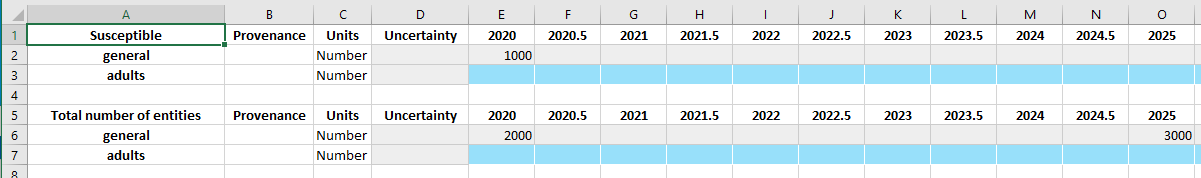

### Further spreadsheet modification

Sometimes it is useful to programatically interact with the *spreadsheet* without writing it to disk - for example, adding an extra sheet, or returning the spreadsheet for download. There are actually three output methods available in the `ProjectData` class

- `ProjectData.to_workbook()` which returns a `BytesIO` instance and an open `xlsxwriter.Workbook`
- `ProjectData.to_spreadsheet()` which takes the output of `to_workbook()`, flushes and closes the `Workbook`, and returns a `ScirisSpreadsheet` instance
- `ProjectData.save()` which takes the output of `to_spreadsheet()` and writes it to disk

For example, to add an extra sheet to the workbook:

In [ ]:
f, workbook = D3.to_workbook() # Get an xlsxwriter workbook instance
worksheet = workbook.add_worksheet('Extra worksheet') # Add a new worksheet
worksheet.write(0, 0, 'Example') # Add some content to the cells
worksheet.write(0, 1, 'Content')
workbook.close()  # Close the workbook to flush any xlsxwriter content
spreadsheet = sc.Spreadsheet(f)  # Wrap it in a spreadsheet instance
spreadsheet.save('sir_databook_10.xlsx')

Now the spreadsheet contains an additional sheet:

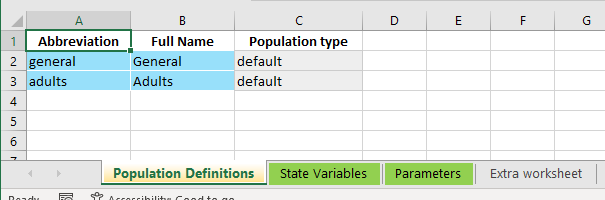

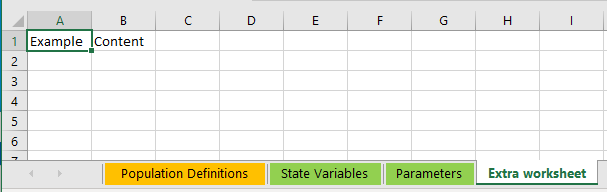